# Convert TIFF Time Series to OME-Zarr (Fiji Compatible)

This notebook reads a sequence of 3D TIFF images (e.g., a time series), stacks them as a 3D array with axes `TCZYX`, and saves the result as a Fiji-compatible OME-Zarr dataset using `ome-zarr-py`.


In [ ]:
# Mount Google Drive (for Colab users)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install required packages (run only once)
!pip install tifffile dask ome-zarr zarr imagecodecs --quiet

## 1. Import Required Libraries

We will use `tifffile` for reading TIFFs, `dask` for lazy evaluation, and `ome-zarr` to write the output in the OME-NGFF format.


In [ ]:
import os
import tifffile
import zarr
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np

from ome_zarr.io import parse_url
from ome_zarr.writer import write_image
from ome_zarr.format import CurrentFormat
from dask import delayed

## 2. Define Input and Output Paths

- `tiff_folder`: Folder containing the TIFF image sequence (each image is a time point).
- `output_zarr`: Path for the resulting OME-Zarr dataset.


In [ ]:
# Define paths (edit these)
#tiff_folder = "/content/drive/MyDrive/2025/Estudiantes/2025 Rodrigo Escobedo/250520/sampleOPCdata"
#output_zarr = "/content/drive/MyDrive/2025/Estudiantes/2025 Rodrigo Escobedo/250520/sampleOPCdata.ome.zarr"

tiff_folder = "/content/drive/MyDrive/2025/Estudiantes/2025 Rodrigo Escobedo/250520/Exp3_MIB2"
output_zarr = "/content/drive/MyDrive/2025/Estudiantes/2025 Rodrigo Escobedo/250520/Exp3_MIB2.ome.zarr"



## 4. Collect and Sort the TIFF Files


In [ ]:
tiff_files = sorted([
    os.path.join(tiff_folder, f)
    for f in os.listdir(tiff_folder)
    if f.lower().endswith(('.tif', '.tiff'))
])
print(f"Found {len(tiff_files)} TIFF files.")

Found 9001 TIFF files.


## 5. Load Dask stack from TIFFs

In [ ]:
stack = da.stack([da.from_array(tifffile.imread(f), chunks="auto") for f in tiff_files])
stack = stack[:, None, None, :, :]  # reshape to (T, C, Z, Y, X)

## 6. Open and visualize first and mean projection

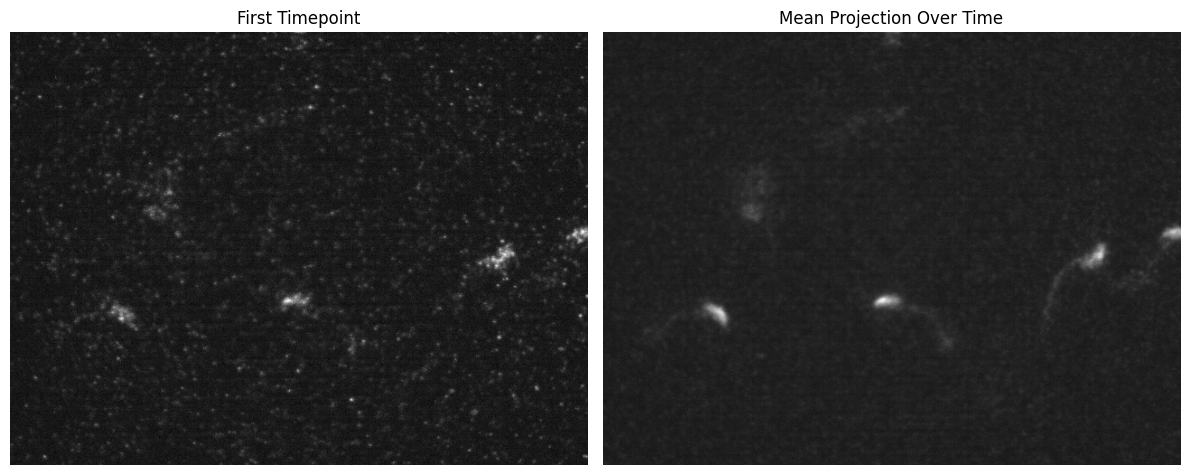

In [ ]:
# Assume grayscale: stack shape is (T, 1, 1, Y, X)
# Extract first image
first_image = stack[0, 0, 0].compute()  # shape (Y, X)

# Compute mean projection over time
mean_projection = stack[0:49, 0, 0].mean(axis=0).compute()  # shape (Y, X)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(first_image, cmap='gray')
ax[0].set_title("First Timepoint")
ax[0].axis('off')

ax[1].imshow(mean_projection, cmap='gray')
ax[1].set_title("Mean Projection Over Time")
ax[1].axis('off')

plt.tight_layout()
plt.show()


## 7. Write the Dataset as OME-Zarr to Google Drive

In [ ]:
# Ensure the Zarr directory exists and get the root group
store = zarr.DirectoryStore(output_zarr)
root_group = zarr.group(store=store, overwrite=True)
write_image(
    image=stack,
    group=root_group,
    axes="tczyx",
    fmt=CurrentFormat(),
    overwrite=True
)
print(f"OME-Zarr saved to: {output_zarr}")

OME-Zarr saved to: /content/drive/MyDrive/2025/Estudiantes/2025 Rodrigo Escobedo/250520/Exp3_MIB2.ome.zarr


## 8. A faster version

In [ ]:
import tifffile
import dask.array as da
import numpy as np
from ome_zarr.writer import write_image
from ome_zarr.io import parse_url

# Lista de archivos TIFF (uno por tiempo, canal, etc.)
tiff_files = sorted([...])  # asegúrate del orden temporal

# Cargar en Dask (aún con tifffile, pero evitando RAM completa)
lazy_arrays = [da.from_array(tifffile.memmap(f), chunks="auto") for f in tiff_files]
stack = da.stack(lazy_arrays)  # shape: (T, Y, X)

# Expandir a (T, C, Z, Y, X) si es necesario
stack = stack[:, None, None, :, :]  # agrega ejes C y Z

# Escribir como OME-Zarr
zarr_path = "output.ome.zarr"
store = parse_url(zarr_path, mode="w").store
write_image(
    image=stack,
    group=store,
    axes="tczyx",  # define los ejes según NGFF
    name="image",
    compute=True
)


## 8. Altrenativamente

In [ ]:
from aicsimageio import AICSImage
from ome_zarr.writer import write_image
from ome_zarr.io import parse_url

img = AICSImage("input.ome.tiff")
data = da.from_array(img.data)  # lazy array
data = data[None, ...]  # convertir a 5D si necesario

store = parse_url("output.ome.zarr", mode="w").store
write_image(data, store, axes="tczyx", name="image", compute=True)
